In [1]:
from pathlib import Path
import os
import time
from itertools import product

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_addons.optimizers import AdamW

from src.model_dino.tf_data import get_tf_data, RandomStandardization
from src.decorrelated_bn.normalization import DecorelationNormalization
from src.models.models import UnetLight, UnetLightDecorrelated

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
h5_file = h5py.File("../data/processed/hdf5_2d/data_selected_slices.hdf5", "r")
clinical_df = pd.read_csv(
    "../data/clinical_info_with_lung_info.csv").set_index("patient_id")

In [3]:
n_slices = 0
for p in h5_file.keys():
    n_slices += h5_file[p]["image"][()].shape[2]

In [4]:
n_slices

5093

In [5]:
BATCH_SIZE = 4
EPOCHS= 100
STEPS_PER_EPOCH = int(510 // BATCH_SIZE) # 5093 slices
STEPS_PER_EPOCH = 200

In [6]:
ds = get_tf_data(
    h5_file,
    clinical_df,
    local_inpainting=False,
    local_shuffling=False,
    n_channels=2,
    return_image=True,
).repeat().batch(BATCH_SIZE).take(STEPS_PER_EPOCH)


In [7]:
for images in ds.take(1).as_numpy_iterator():
    pass

In [8]:
images[0].shape

(4, 256, 256, 2)

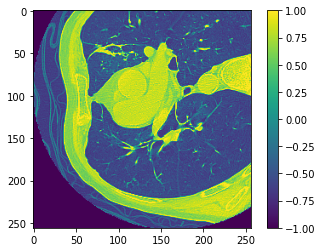

In [9]:
plt.imshow(images[2][0,:, :, 0])
plt.colorbar()

In [31]:
def get_last(output_channels, last_decorrelation=False):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 3, activation="relu", padding="SAME"),
        DecorelationNormalization(decomposition="iter_norm_wm", iter_num=5),
        tf.keras.layers.Conv2D(output_channels,
                               1,
                               activation="linear",
                               padding='SAME'),
    ])
    if last_decorrelation:
        model.add(
            DecorelationNormalization(
                decomposition="iter_norm_wm",
                iter_num=5,
            ))
    return model


In [32]:
model_t = tf.keras.Sequential([
    UnetLight(last_activation="linear", include_last=False),
    get_last(100),
])


In [33]:
inputs = tf.keras.Input(shape=(256, 256, 2))
x_m = UnetLight(last_activation="linear", include_last=False)(inputs)
x_dino = get_last(100)(x_m)
x_r = get_last(2)(x_m)
model_s = tf.keras.Model(inputs=inputs, outputs=[x_dino, x_r])

In [34]:
model_s.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
unet_light_4 (UnetLight)        (None, 256, 256, 8)  505816      input_3[0][0]                    
__________________________________________________________________________________________________
sequential_52 (Sequential)      (None, 256, 256, 100 1572        unet_light_4[0][0]               
__________________________________________________________________________________________________
sequential_53 (Sequential)      (None, 256, 256, 2)  690         unet_light_4[0][0]               
Total params: 508,078
Trainable params: 506,446
Non-trainable params: 1,632
________________

In [35]:
# model_s.load_weights("/home/valentin/python_wkspce/plc_segmentation/models/dino/model_s2/final")
# model_t.load_weights("/home/valentin/python_wkspce/plc_segmentation/models/dino/model_t2/final")

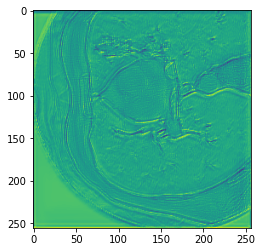

In [36]:
plt.imshow(model_s(images[2])[1][0, :, :, 0])


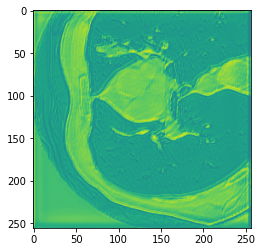

In [37]:
plt.imshow(model_t(images[2])[0, :, :, 0])

In [38]:
# for k, w in enumerate(model_s.trainable_variables):
#     model_t.trainable_variables[k] = w

In [39]:
# Instantiate an optimizer to train the model.
# Instantiate a loss function.
tau_s = 0.1
tau_t = 0.04
m = 0.9
momentum_teacher = 0.996
weight_decay = 0.04
weight_decay_end = 0.4
lr = 1e-3
min_lr = 1e-6
# optimizer = AdamW(learning_rate=lr, weight_decay=weight_decay)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


In [40]:
def cosine_scheduler(base_value,
                     final_value,
                     epochs,
                     niter_per_ep,
                     warmup_epochs=0,
                     start_warmup_value=0):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value,
                                      warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (
        1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule

In [41]:
momentum_schedule = cosine_scheduler(momentum_teacher, 1, EPOCHS,
                                     STEPS_PER_EPOCH).astype(np.float32)


In [42]:
wd_schedule = cosine_scheduler(
    weight_decay,
    weight_decay_end,
    EPOCHS,
    STEPS_PER_EPOCH,
)


In [43]:
lr_schedule = cosine_scheduler(
    lr,  # linear scaling rule
    min_lr,
    EPOCHS,
    STEPS_PER_EPOCH,
    warmup_epochs=10,
)
lr_schedule = np.ones((EPOCHS * STEPS_PER_EPOCH)) * 1e-3


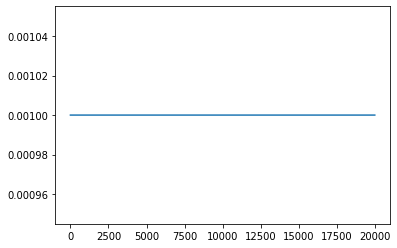

In [44]:
plt.plot(lr_schedule)

In [45]:
@tf.function
def dino_loss(y_s, y_t, center=0):
    s = tf.nn.log_softmax(y_s / tau_s, axis=-1)
    t = tf.stop_gradient(tf.nn.softmax((y_t - center) / tau_t, axis=-1))
    return -tf.reduce_mean(tf.reduce_sum(t * s, axis=-1))


In [46]:
@tf.function
def mse_loss(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred)**2)


In [47]:
@tf.function
def entropy(y_pred, tau):
    y_pred = tf.nn.softmax(y_pred / tau, axis=-1)
    log_y_pred = tf.nn.log_softmax(y_pred / tau, axis=-1)
    return -tf.reduce_mean(tf.reduce_sum(y_pred * log_y_pred, axis=-1))


In [48]:
@tf.function
def train_step(images,
               momentum_teacher,
               optimizer=None,
               center=0,
               mse_weight=100):
    original_image = images[0]
    images = images[1:]
    global_x = images[:2]

    y_t = list()
    for x in global_x:
        y_t.append(model_t(x, training=True))  # Forward pass

    if center is None:
        center = tf.reduce_mean(tf.concat(y_t, axis=0), axis=(0, 1, 2))

    with tf.GradientTape() as tape:
        outputs_s = list()
        for x in images:
            outputs_s.append(model_s(x, training=True))  # Forward pass
        y_s, reconstructed_images = list(zip(*outputs_s))
        loss_1 = 0
        n_loss = 0
        for s_ind, t_ind in product(range(len(y_s)), range(len(y_t))):
            if s_ind == t_ind:
                continue
            loss_1 += dino_loss(y_s[s_ind], y_t[t_ind], center=center)
            n_loss += 1

        loss_1 = loss_1 / n_loss

        loss_2 = 0
        n_loss = 0
        for x in reconstructed_images:
            loss_2 += mse_loss(original_image, x)
            n_loss += 1

        loss_2 = loss_2 / n_loss
        loss = loss_1 + mse_weight * loss_2

    # Compute gradients
    gradients = tape.gradient(loss, model_s.trainable_variables)
    gradients = [tf.clip_by_norm(g, 1) for g in gradients]

    # Update weights
    optimizer.apply_gradients(zip(gradients, model_s.trainable_variables))

    for k, w in enumerate(model_t.layers[0].weights):
        model_t.layers[0].weights[k].assign(momentum_teacher * w +
                                            (1 - momentum_teacher) *
                                            model_s.layers[1].weights[k])

    for k, w in enumerate(model_t.layers[1].weights):
        model_t.layers[1].weights[k].assign(momentum_teacher * w +
                                            (1 - momentum_teacher) *
                                            model_s.layers[2].weights[k])

    center = m * center + (1 - m) * tf.reduce_mean(tf.concat(y_t, axis=0),
                                                   axis=(0, 1, 2))
    return loss_1, loss_2, center


In [49]:
center = None
total_step = 0

In [50]:
for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch, ))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, images in enumerate(ds):
        optimizer.lr = lr_schedule[step]
        # optimizer.weight_decay = wd_schedule[step]
        d_loss, m_loss, center = train_step(images,
                                        momentum_schedule[total_step],
                                        optimizer=optimizer,
                                        center=center)

        # Log every 200 batches.
        if step % 10 == 0:
            print(f"Training dino loss: {d_loss} and mse: {m_loss} at step: {step}")
            print(f"entropy on batch: {entropy(model_t(images[0]),tau=tau_t)}")
            print("Seen so far: %d samples" % ((step + 1) * BATCH_SIZE))

        total_step += 1

    print("Time taken: %.2fs" % (time.time() - start_time))



Start of epoch 0
Training dino loss: 7.671510696411133 and mse: 1.9536323547363281 at step: 0
entropy on batch: 4.178677558898926
Seen so far: 4 samples
Training dino loss: 5.937042236328125 and mse: 0.5438242554664612 at step: 10
entropy on batch: 4.202037811279297
Seen so far: 44 samples
Training dino loss: 5.635622978210449 and mse: 0.41769352555274963 at step: 20
entropy on batch: 3.8692126274108887
Seen so far: 84 samples
Training dino loss: 5.305327415466309 and mse: 0.39402341842651367 at step: 30
entropy on batch: 3.282627820968628
Seen so far: 124 samples
Training dino loss: 4.942714691162109 and mse: 0.35711872577667236 at step: 40
entropy on batch: 1.1761984825134277
Seen so far: 164 samples
Training dino loss: 4.65864896774292 and mse: 0.30331650376319885 at step: 50
entropy on batch: 0.21367785334587097
Seen so far: 204 samples
Training dino loss: 4.49778938293457 and mse: 0.2851235866546631 at step: 60
entropy on batch: 0.08606618642807007
Seen so far: 244 samples
Traini

KeyboardInterrupt: 

In [51]:
pred = tf.nn.softmax(model_s(images[3])[0]/tau_s , axis=-1).numpy()
recons = model_s(images[3])[1].numpy()
# pred = model_s(images[3]).numpy()

In [52]:
pred.shape

(4, 256, 256, 100)

In [53]:
np.min(pred)

0.0

In [54]:
def power(y_pred):
    return np.sqrt(np.mean(y_pred**2, axis=(0, 1)))


In [55]:

np.where(power(pred[0,...])>0.02)

(array([ 0,  3,  4,  5,  6,  8, 17, 38, 57, 59, 64, 74, 85, 88, 90, 93]),)

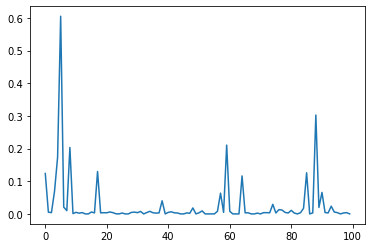

In [56]:
plt.plot(power(pred[0,...]))

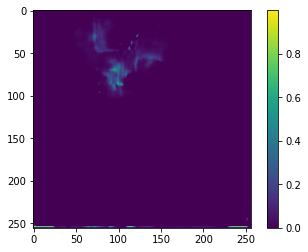

In [58]:
plt.imshow(pred[1,:,:,3])
plt.colorbar()
plt.savefig("test.png", dpi=600)

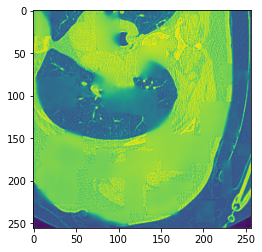

In [59]:
plt.imshow(recons[1,:,:,0])

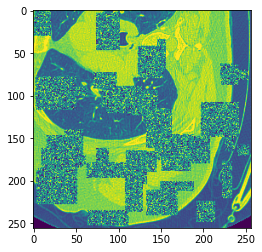

In [60]:
plt.imshow(images[3][1,:,:,0])
# plt.imshow(images[0].numpy()[0,:,:,0])

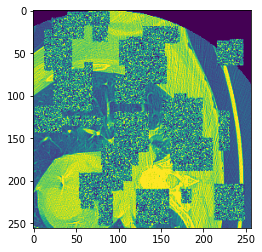

In [61]:
plt.imshow(images[3].numpy()[0,:,:,0])

In [62]:
from src.data.utils import get_split
from sklearn.neighbors import NearestNeighbors

In [63]:
ids_train, ids_val, ids_test = get_split(0)

In [64]:
def get_cropped_image(image, mask, output_shape_image=(256, 256)):
    positions = np.where(mask != 0)
    s = int((np.max(positions[2]) + np.min(positions[2])) / 2)
    bb_lung = get_bb_mask_voxel(mask[..., 2] + mask[..., 3])
    center = ((bb_lung[:3] + bb_lung[3:]) // 2)[:2]
    r = [output_shape_image[i] // 2 for i in range(2)]
    mask = mask[center[0] - r[0]:center[0] + r[0],
                center[1] - r[1]:center[1] + r[1], s, 0]

    image = image[center[0] - r[0]:center[0] + r[0],
                  center[1] - r[1]:center[1] + r[1], s, :]

    return image, mask


def get_bb_mask_voxel(mask):
    positions = np.where(mask != 0)
    x_min = np.min(positions[0])
    y_min = np.min(positions[1])
    z_min = np.min(positions[2])
    x_max = np.max(positions[0])
    y_max = np.max(positions[1])
    z_max = np.max(positions[2])
    return np.array([x_min, y_min, z_min, x_max, y_max, z_max])


In [65]:
def get_images(file, ids, output_shape_image=(256, 256), standardizer=None):
    images = list()
    masks = list()
    for i in ids:
        image = file[i]["image"][()]
        mask = file[i]["mask"][()]
        im, m = get_cropped_image(
            image,
            mask,
            output_shape_image=output_shape_image,
        )
        if standardizer:
            im = standardizer(im)
        images.append(im)
        masks.append(m)
    return np.stack(images, axis=0), np.stack(masks, axis=0)


In [66]:
standardizer = RandomStandardization(p=0)

In [67]:
images_train, masks_train = get_images(h5_file,
                                       ids_train,
                                       standardizer=standardizer)
images_val, masks_val = get_images(h5_file, ids_val, standardizer=standardizer)
images_test, masks_test = get_images(h5_file,
                                     ids_test,
                                     standardizer=standardizer)


In [ ]:
plt.imshow(masks_train[0,:,:])


In [ ]:
plt.imshow(images_train[0,:,:,0])
plt.colorbar()

In [ ]:
pred = tf.nn.softmax(model_s(images_train[:1,...])[0]/tau_s).numpy()

In [ ]:
plt.plot(power(pred[0,...]))

In [ ]:
plt.imshow(pred[0,:,:,32])

In [68]:
from sklearn.cluster import KMeans

In [89]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(np.reshape(images_train, [-1, 2]))

KeyboardInterrupt: 

In [ ]:
pred_test = np.reshape(kmeans.predict(np.reshape(images_test, [-1, 2])), [-1,256,256,1])

In [ ]:
pred_test.shape

In [ ]:
plt.imshow(pred_test[19,:,:,0])

In [69]:
preds_train = tf.nn.softmax(model_s(images_train)[0] / tau_s).numpy()


In [90]:
kmeans_dino = KMeans(n_clusters=20, random_state=0).fit(np.reshape(preds_train, [-1, 100]))

In [91]:
pred_dino_test = np.reshape(
    kmeans_dino.predict(
        np.reshape(
            tf.nn.softmax(model_s(images_test)[0] / tau_s).numpy(), [-1, 100])),
    [-1, 256, 256, 1])


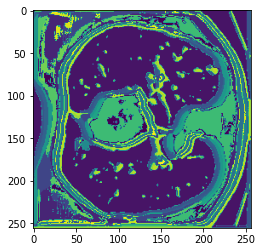

In [92]:
plt.imshow(pred_dino_test[13,:,:,0])

In [93]:
def colorize(y_pred):
    indices = np.unique(y_pred)
    indices = np.delete(indices, 0)
    output = np.zeros(y_pred.shape + (3, ))
    for i in indices:
        color = np.random.uniform(size=(3, ))
        positions = np.where(y_pred == i)
        output[positions[0], positions[1], :] = color
    return output

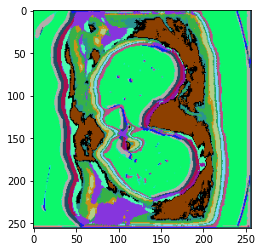

In [102]:

plt.imshow(colorize(pred_dino_test[15,:,:,0]))

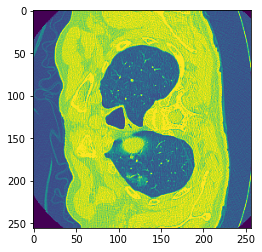

In [104]:
plt.imshow(images_test[15,:,:,0])

In [ ]:
plt.imshow(masks_test[11,:,:])